### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

### Load Data

In [2]:
pdx_prep = pd.read_csv('pdx_prep.csv')

In [3]:
pdx_prep.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712 entries, 0 to 2711
Data columns (total 193 columns):
 #    Column                                    Non-Null Count  Dtype  
---   ------                                    --------------  -----  
 0    id                                        2712 non-null   int64  
 1    host_id                                   2712 non-null   int64  
 2    host_since                                2712 non-null   object 
 3    host_response_rate                        2712 non-null   float64
 4    host_acceptance_rate                      2712 non-null   float64
 5    host_is_superhost                         2712 non-null   float64
 6    host_listings_count                       2712 non-null   int64  
 7    host_total_listings_count                 2712 non-null   int64  
 8    host_has_profile_pic                      2712 non-null   int64  
 9    host_identity_verified                    2712 non-null   int64  
 10   accommodates          

#### Split/Scale for training

In [4]:
X_train, X_test, y_train, y_test = train_test_split(pdx_prep.drop(columns='price'), 
                                                    pdx_prep.price, test_size=0.3, 
                                                    random_state=47)

# removed price as our target feature

In [5]:
date_list = ['host_since', 'first_review', 'last_review']
date_train = X_train[date_list]
date_test = X_test[date_list]
X_train.drop(columns=date_list, inplace=True)
X_test.drop(columns=date_list, inplace=True)
X_train.shape, X_test.shape

# removed datetime columns since they are not numeric

((1898, 189), (814, 189))

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1898 entries, 254 to 1159
Columns: 189 entries, id to rt__Shared room
dtypes: float64(167), int64(22)
memory usage: 2.8 MB


All dtypes are numeric (either float64 or int64)

In [7]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814 entries, 1886 to 2230
Columns: 189 entries, id to rt__Shared room
dtypes: float64(167), int64(22)
memory usage: 1.2 MB


All dtypes are numeric (either float64 or int64)

### Establish baseline

In [8]:
# how good is the average at predicting cost? save as 'baseline' to easily check later

dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
baseline = dumb_reg.constant_

print(baseline)

[[129.5426765]]


#### sklearn metrics

In [9]:
y_tr_pred = dumb_reg.predict(X_train)

In [10]:
y_te_pred = dumb_reg.predict(X_test)

In [11]:
print("y_train shape is ", y_train.shape)
print("y_test shape is ", y_test.shape)
print("y_tr_pred shape is ", y_tr_pred.shape)
print("y_te_pred shape is ", y_te_pred.shape)

y_train shape is  (1898,)
y_test shape is  (814,)
y_tr_pred shape is  (1898,)
y_te_pred shape is  (814,)


In [12]:
# r2 score 

r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0001001159840232635)

<i>(From guided capstone) 
The baseline model here, which always predicts the sample mean, should give r^2=0.<br>
A model that perfectly predicts the observed values would have no residual error and so give r^2=1.<br>
Models that do worse than predicting the mean will have increased the sum of squares of residuals and so produce a negative r^2.</i>

In [13]:
# mae score

mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(66.54958077994586, 64.69977837786058)

<i>(From guided capstone) 
Mean absolute error is arguably the most intuitive of all the metrics, this essentially tells you that, on average, you might expect to be off by around 64-66 dollars if you guessed price based on an average of known values.</i>

In [14]:
# mse score

mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(59106.075365228324, 50308.81564509418)

<i>(From guided capstone) This is simply the average of the square of the errors.</i>

### Initial Models

#### Linear Regression

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [16]:
# train model

lm = LinearRegression().fit(X_tr_scaled, y_train)

In [17]:
# make predictions on both splits

y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [18]:
# assess performance

print("R2 is ", r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred))
print("MAE is ", mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred))
print("MSE is ", mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred))

R2 is  0.5342063336345558 -2.7528014707308967e+21
MAE is  65.0822705618773 945960746712.135
MSE is  27531.23554884196 1.3847631800570373e+26


Well that looks significantly worse than just using the baseline. Since R2 shows improvement on train but significant deterioration on test, my guess is that this model is overfitting. 

#### Select K Best

In [19]:
# make pipeline

pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [20]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000001DBAB7A0360>)),
                ('linearregression', LinearRegression())])

In [21]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [22]:
print("R2 is ", r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred))
print("MAE is ", mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred))
print("MSE is ", mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred))

R2 is  0.4662802672749906 0.46636189129023187
MAE is  62.45961574198785 62.24466168206663
MSE is  31546.07874635392 26844.013717427995


Better than linear regression, but R2 is still too low. 

#### Cross Validation

In [23]:
cv_results = cross_validate(pipe, X_train, y_train, cv=5)

In [24]:
cv_scores = cv_results['test_score']
cv_scores

array([ 0.43165509, -1.84271271, -1.17760216, -2.12781917,  0.48003845])

In [25]:
np.mean(cv_scores), np.std(cv_scores)

(-0.8472880985390729, 1.10790151422955)

In [26]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([-3.06,  1.37])

#### GridSearchCV

In [27]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__positive'])

In [28]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [29]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [30]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001DBAB7A0360>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [31]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [32]:
lr_grid_cv.best_params_

{'selectkbest__k': 1}

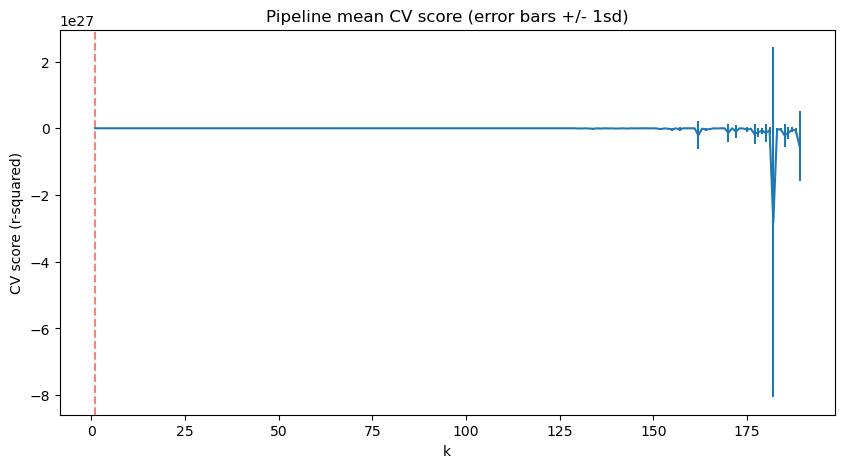

In [33]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

This is getting steadily worse.

#### Random Forest

In [34]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [35]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [36]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([ 0.64721467, -1.39381566,  0.31435764, -0.68330915,  0.61014932])

In [37]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(-0.1010806360257874, 0.806044262968687)

In [38]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [39]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [40]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [41]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 297,
 'standardscaler': StandardScaler()}

In [42]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([ 0.66431353, -1.47305798,  0.30092194, -0.27355348,  0.63312505])

In [43]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(-0.02965018912138484, 0.7966240582168357)

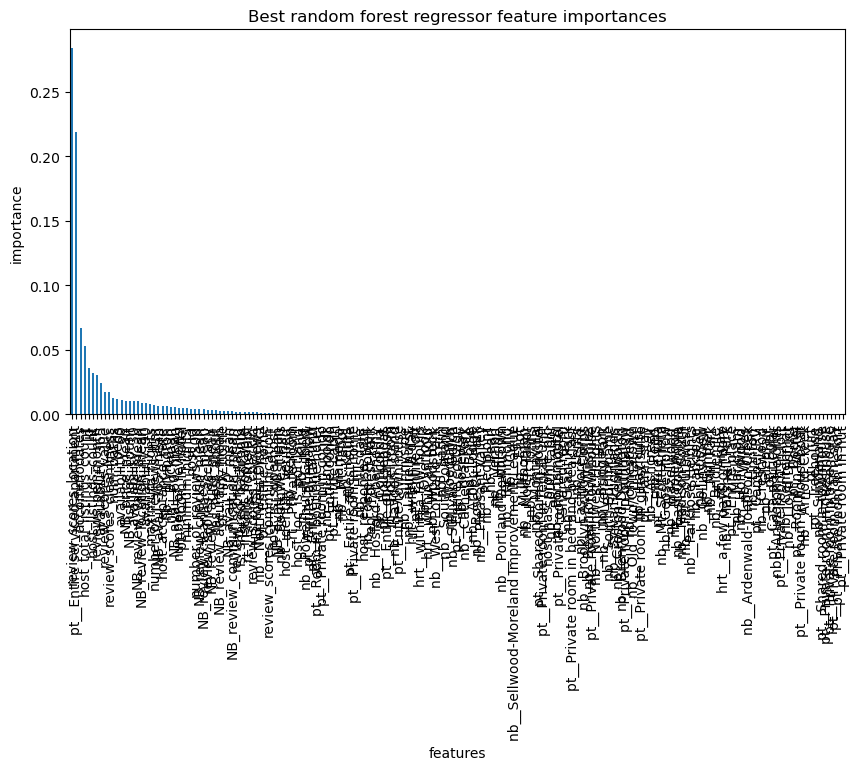

In [46]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [47]:
print(rf_feat_imps[:10])

review_scores_location           0.284219
pt__Entire serviced apartment    0.218886
accommodates                     0.067125
host_total_listings_count        0.053041
id                               0.036174
host_listings_count              0.032181
reviews_per_month                0.030335
availability_365                 0.024642
review_scores_value              0.017166
review_scores_cleanliness        0.017138
dtype: float64
